## Library imports and iPython settings

In [20]:
# Full library imports
import random
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
import skimage.color as skc

# Selective library imports
from os import listdir, getcwd
from pylab import rcParams
from numpy import histogram, interp, cumsum, diff
from os.path import isfile, join
from matplotlib import cm
from sklearn.tree import DecisionTreeClassifier
from scipy.ndimage import imread
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegressionCV

#ipython setting
rcParams['figure.figsize'] = (10, 6)

# Histogram equalization

1. To get $ f: D \rightarrow \left[ 0, M\right]$, simply scale the cumulative distribution function $H_f \left( v \right)$ with the factor M. This gives: $\psi = M \cdot H_f \left( v \right)$

2. The following program  takes in a simple image and runs a histogram equalization algorithm. After this the original picture and the equalised picture are shown together with their histograms. The image is read with scipy ensuring it is read into memory as a uint8 array.

In [84]:
BINS = 100
IM_SIZE = 255

def histogramEqualization(f, bins=BINS):
    his, be = histogram(f, range=(0,IM_SIZE), bins=bins)
    hist = his.astype(float)/sum(his)
    return interp(f, be[1:], cumsum(hist)), his, be

def get_image_set(path):
    
    img_loc = getcwd() + '/' + path + '/'
    img_list = [img_loc + f for f in listdir(img_loc)]
    
    return img_list

def eq_img(dataset):
    
    imgset = get_image_set('different_angles/' + dataset)
    imgset_size = len(imgset)
    
    fig, axarr = plt.subplots(imgset_size, 4)
    
    for i in range(imgset_size):
        
        f = imread(imgset[i])
        f_eq, his_img, be_img = histogramEqualization(f)
        his_eq, be_eq = histogram(f_eq, range=(0,1), bins=BINS)
        
        axarr[i, 0].imshow(f)
        axarr[i, 1].bar((be_img[:-1] + be_img[1:]) / 2, his_img, align='center', width=diff(be_img))
        axarr[i, 2].imshow(f_eq)
        axarr[i, 3].bar((be_eq[:-1] + be_eq[1:]) / 2, his_eq, align='center', width=diff(be_eq))
        axarr[i, 0].axis('off')
        axarr[i, 1].axis('off')
        axarr[i, 2].axis('off')
        axarr[i, 3].axis('off')

    plt.show()
    
def single_im_eq(file):
    
    #Read figure and equalise
    img = scimg.imread(file)
    img_eq, his, be = histogramEqualization(img)

    f, axarr = plt.subplots(2, 2)

    #plot histogram of original data
    axarr[1, 0].bar((be[:-1] + be[1:]) / 2, his, align='center', width=diff(be))
    axarr[1, 0].set_xticks([be[x] for x in range(0, len(be), int(BINS/10))])

    # Show original image
    axarr[0, 0].imshow(img, cmap='gray')

    #plot histogram of equalized image
    his, be = histogram(img_eq, range=(0,1), bins=BINS)
    axarr[1, 1].bar((be[:-1] + be[1:]) / 2, his, align='center', width=diff(be))
    axarr[1, 1].set_xticks([be[x] for x in range(0, len(be), int(BINS/10))])

    # Show equalized image
    axarr[0, 1].imshow(img_eq, cmap='gray')

    plt.show()

The  above code defines functions which are run below, for seperation of definition and execution

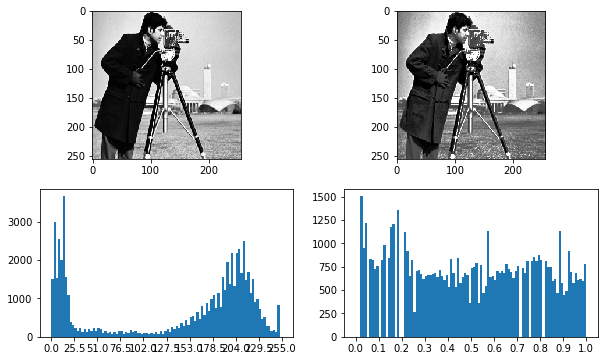

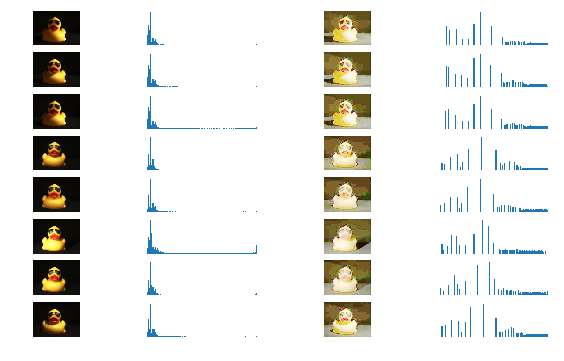

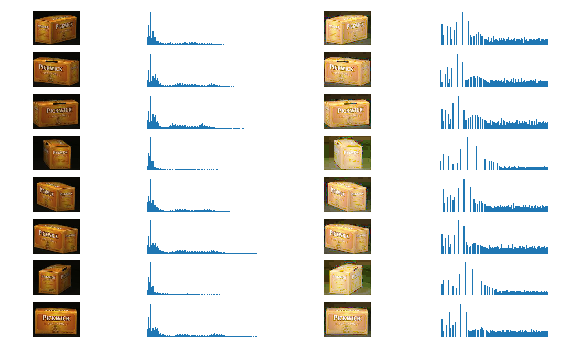

In [87]:
# Test histogram equalization for a single image
single_im_eq("cameraman1.png")
# Test histogram equalization for an entire dataset
eq_img("duck")
eq_img("tea")

# Skin color detection

1. Plot a 3d-scatter plot of RGB values of skin and non-skin colors. Plots the points corresponding to skin color in green and the points corresponding to non-skin color in red.

In [ ]:
# Amount of samples taken in plotting 3D scatter
SAMPLES = 500

# Randomly takes n points from a numpy array
def sample(ar, n):

    i = 0
    sample = 0
    # Create empty holder array
    samples = np.zeros(n)

    while i < len(ar) and sample < n:

        # 50% chance to select item, not critical in this
        # implementation (just used for speeding up program)
        if random.random() > .5:

            samples[sample] = ar[i]
            sample += 1

        i += 1

    return samples

#Read images
# f = imread('SkinColor/FacePhoto/0520962400.jpg')
# m = imread('SkinColor/GroundT_FacePhoto/0520962400.png')
f = imread('SkinColor/FamilyPhoto/buck_family.jpg')
m = imread('SkinColor/GroundT_FamilyPhoto/buck_family.png')

skincolors = f[m[:,:,0]==255]
nonskincolors = f[m[:,:,0]==0]

# Take a selection of SAMPLES points to plot in 3D plot for
# both skin- and non-skin colors
x, y, z = np.split(skincolors, 3, 1)
x = sample(x, SAMPLES)
y = sample(y, SAMPLES)
z = sample(z, SAMPLES)

t, u, v = np.split(nonskincolors, 3, 1)
t = sample(x, SAMPLES)
u = sample(y, SAMPLES)
v = sample(z, SAMPLES)

# 3D scatter plot of randomly selected points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=30, c='green')
ax.scatter(t, u, v, s=30, c='red')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
plt.show()

Train classifier for use with skin color detection

In [ ]:
# Convert image to lab color convention taking only the ab dimensions
f_lab = skc.rgb2lab(f)[::, ::, 1::]
# Extract skin- and non-skin colors from image data
sc_lab = f_lab[m[:,:,0]==255]
nsc_lab = f_lab[m[:,:,0]==0]

# Scatter plot of a selection of skin and non-skin colors
plt.scatter(sc_lab[::25, 0], sc_lab[::25, 1], s=1, marker=',', color='green')
plt.scatter(nsc_lab[::25, 0], nsc_lab[::25, 1], s=1, marker=',', color='red')
plt.xlabel("a")
plt.ylabel("b")
plt.show()

# Combine the skin and non-skin color feature vectors into a single item
# And do this for the classes corresponding to the colors
color = np.vstack((sc_lab, nsc_lab))
target = np.concatenate((np.ones(len(sc_lab)),np.zeros(len(nsc_lab))))

# Take half the data to learn the classifier and use the other half to
# test it
learn_color = color[1::2]
test_color = color[0::2]
learn_target = target[1::2]
test_target = target[0::2]
logregr = LogisticRegressionCV()
logregr.fit(learn_color, learn_target)

print("Score of logistic regression:")
print(logregr.score(test_color, test_target))

image_colors = f_lab.reshape((-1,2))
predict_skin = logregr.predict(image_colors).reshape(f_lab.shape[:2])

plt.subplot(121)
plt.imshow(f)
plt.subplot(122)
plt.imshow(predict_skin)
plt.show()

To get a generally applicable classifier we need to train it with more than just one picture. Also, using the same picture we trained with as a test is questionable to say the least. Though the princimple has been proven the need for more training data is necessary.

In the following program a loop is called for all pictures in the directory and then they are used for training the classifier. A subset of pixels is used to reduce the large amount of data. Then the classifier is tested on another folder of images which will check the validity of the classifier.

In [17]:
# Train data path
REL_PATH_FACE = 'SkinColor/FacePhoto/'
REL_PATH_MASK = 'SkinColor/GroundT_FacePhoto/'

# Test data path
REL_PATH_FAM = 'SkinColor/FamilyPhoto/'

# Classifier parameters:
NNB = 5
MAX_DEPTH = 10
ALPHA = 1

def read_image(file, sample_interval):
    
    f = imread(REL_PATH_FACE + file)
    # Only take .jpg and .jpeg files
    if file[-4:] == ".jpg":
        m = imread(REL_PATH_MASK + file[:-4] + '.png')
    elif file[-4:] == "jpeg":
        m = imread(REL_PATH_MASK + file[:-4] + 'png')
    else:
        return np.zeros([1, 1]), np.zeros([1, 1])
        
    # Convert image to lab color convention taking only the ab dimensions
    # and every 100th element to reduce sheer amount of data
    f_lab = skc.rgb2lab(f)[::, ::sample_interval, 1::]
    # Extract skin- and non-skin colors from image data
    sc_lab = f_lab[m[:, ::sample_interval, 0]==255]
    nsc_lab = f_lab[m[:, ::sample_interval, 0]==0]
        
    color = np.vstack((sc_lab, nsc_lab))
    target = np.concatenate((np.ones(len(sc_lab)),np.zeros(len(nsc_lab))))
    
    return color, target
    
# Reads image data from current directory with hierarchy as given in 
# the exercise.
def read_image_folder(sample_interval):
    
    mypath = getcwd()
    original = mypath + '/' + REL_PATH_FACE
    original_list = [f for f in listdir(original)]
    original_list.sort()
    
    # Set up initial data vector to whcih other will be appended
    data_vector, target_vector = read_image(original_list[1], sample_interval)
    
    for file in original_list[1:]:
        
        c, t = read_image(file, sample_interval)
        
        if c.all() == 0 and t.all() == 0:
            continue
        
        data_vector = np.concatenate((data_vector, c))
        target_vector = np.concatenate((target_vector, t))
    
    return data_vector, target_vector

def read_random_image(dataset):
    
    if dataset == "family":
        dataset = REL_PATH_FAM
    elif dataset == "face":
        dataset = REL_PATH_FACE
    
    mypath = getcwd()
    img_loc = mypath + '/' + dataset
    img_list = [f for f in listdir(img_loc)]
    
    img_index = random.randint(0, len(img_list) - 1)
    
    return imread(dataset + img_list[img_index]) 

from sklearn.neural_network import MLPClassifier

class skin_color_classifier:
    
    def __init__(self, data, target, classifier="logreg",
                 max_depth = MAX_DEPTH, nnb=NNB, alpha=ALPHA):
        
        if classifier == "logreg":
            self.classifier = LogisticRegressionCV()
        elif classifier == "tree":
            self.classifier = DecisionTreeClassifier(max_depth=max_depth)
        elif classifier == "KNNB":
            self.classifier = KNeighborsClassifier(nnb)
        elif classifier == "MLP":
            self.classifier = MPLClassifier(alpha=1)
        self.classifier_type = classifier
        self.data = data
        self.target = target
        
    def train(self):
        
        self.classifier.fit(self.data, self.target)
        
    def predict(self, image, plot="true"):
        
        # Take only ab dimensions of LAB color space and reshape data
        image_colors = skc.rgb2lab(image)[::, ::, 1::].reshape((-1, 2))
        prediction = self.classifier.predict(image_colors).reshape(image.shape[:2])
        
        if plot:
            self.plot_image(image, prediction)
        
        
    def plot_image(self, image, prediction):
        
        plt.subplot(121)
        plt.imshow(image)
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(prediction)
        plt.axis("off")
        plt.show()

# Get training data
clrs, trgts = read_image_folder(100)

# Create classifiers and train using training data
logregr = skin_color_classifier(clrs, trgts)
logregr.train()
print("Logistic regression trained.")
tree = skin_color_classifier(clrs, trgts, "tree", max_depth=MAX_DEPTH)
tree.train()
print("Tree classifier trained with %s max depth trained." % (MAX_DEPTH))
KNNB = skin_color_classifier(clrs, trgts, "KNNB", nnb=NNB)
KNNB.train()
print("K nearest neghbor classifier trained with %s nearest neighbors trained." % (NNB))
MLP = skin_color_classifier(clrs, trgts, "KNNB", alpha=ALPHA)
MLP.train()
print("Multi-layer perceptron classifier with alpha = %s trained." % (ALPHA))

print("Done training")

Logistic regression trained.
Tree classifier trained with 5 max depth trained.
K nearest neghbor classifier trained with 3 nearest neighbors trained.
Multi-layer perceptron classifier with alpha = 1 trained.
Done training


In the next section of code it is possible to test the quality of a selection of classifiers. By running the loop an image can be loaded from disk and will be checked with the chosen classifier. The classifiers are all trained in the previous section and can be retrained with different parameters by setting these in the constants defined below and running the above section again.

logreg


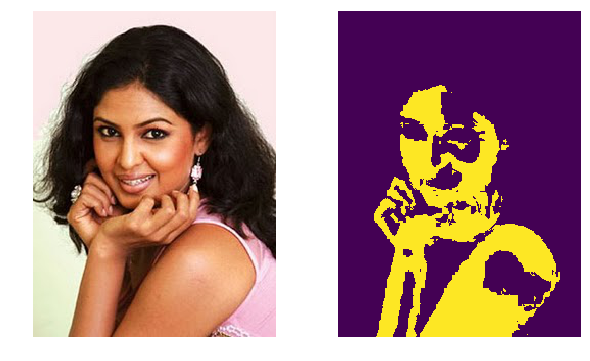

family
logreg


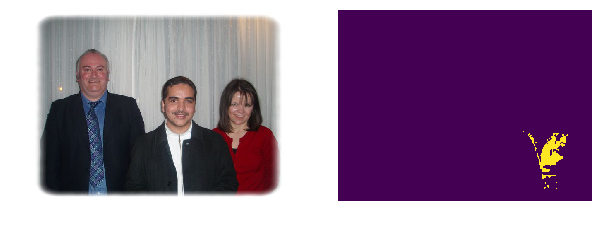

logreg


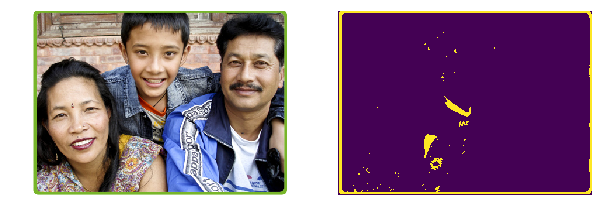

tree


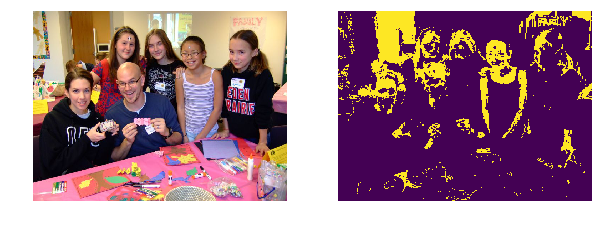

MLP


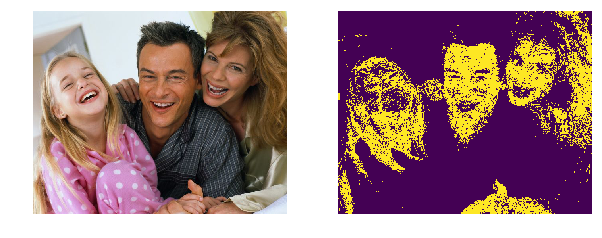

MLP


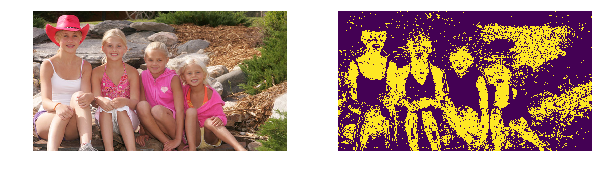

MLP


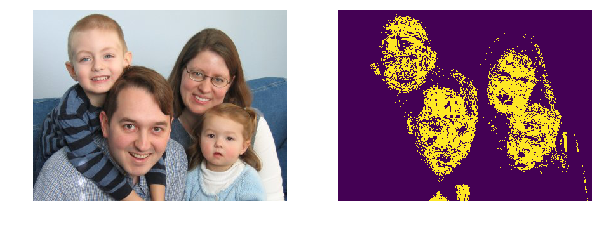

MLP


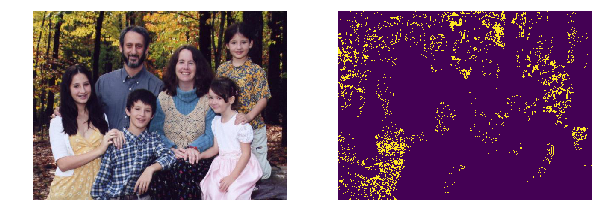

MLP


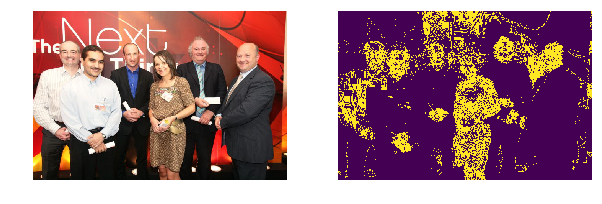

MLP


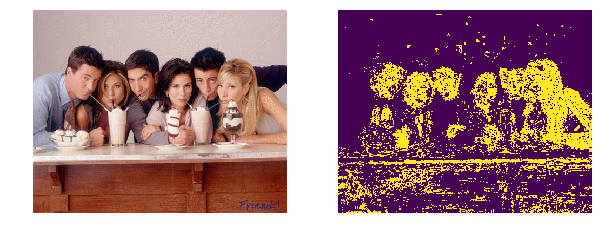

tree


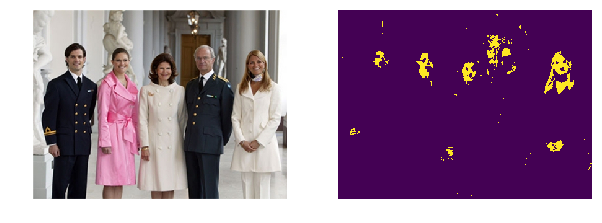

tree


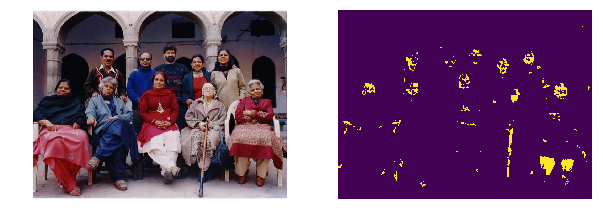

q


In [19]:
NNB = 5
MAX_DEPTH = 10
ALPHA = 1

# Setup initial source (family or face photo's)
source = 'face'

# As long as user keeps asking for images, keeps classifying them
#     (input = "classifier type")
# When done enter 'q'
while True:
    inp = input()
    if inp == 'family' or inp == 'face':
        source = inp
    elif inp == 'logreg':
        test_img = read_random_image(source)
        logregr.predict(test_img)
    elif inp == 'tree':
        test_img = read_random_image(source)
        tree.predict(test_img)
    elif inp == 'KNNB':
        test_img = read_random_image(source)
        KNNB.predict(test_img)
    elif inp == 'MLP':
        test_img = read_random_image(source)
        MLP.predict(test_img)
    elif inp == 'q':
        break
    else:
        continue

Although no extensive formal testing has been conducted, it can easily be seen that the classifier has trouble with colors that are close to skin color. For example; walls, sand or clothing is frequently misclassified. Also the logistic regression classifier seems to have an obsession with red in some cases. The way it has currently been set up, the tree and KNNB  classifiers seem to perform better than simple logistic regression though as suggested, contextual information (surronding pixels) might help with getting more accurate results. The absolute winner of the classifiers I tried seems to be the multi-layer perceptron neural network classifier, face features are very clear and misclassification seems minimal in comparison to the other classifiers.
Running the classifiers on the other dataset (family) has varying results, some pictures are classified with near perfect accuracy while some pictures are completele misclassified.
I also tried getting a gaussion classifier and an SVM to work but unfortunately this either crashed or refused to run altogether.